<a href="https://colab.research.google.com/github/LucaZheng/CarRacingV2_PPO/blob/main/CarracingV2final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libararies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gymnasium
!pip install moviepy
!pip install swig
!pip install gymnasium[box2d]
!pip install ale-py renderlab

In [3]:
import os
import numpy as np
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import torch.nn.init as init
import torch.optim as optim
import warnings

# Build Memories Methods

In [4]:
"""
  Notes:
  lists used to store infos from the env. Including a whole collection of trajectories
  e.g. if your choose to collect 1,000 state for n_epochs of training,
  then len(self.states) is 1,000. It means you want 1,000 data points for the
  network to update(n_epochs/update) each time.

  if batch_size = 100, then you will be training 10 batches(1,000/100),
  with random datapoints over n_epochs.
"""
class PPOMemory:

  def __init__(self, batch_size):
    self.states = []
    self.probs = []   # store for calculate probs/old_probs later
    self.actions = []
    self.vals = []
    self.rewards = []
    self.dones = []   # 0,1 as flages to determine when rewards need to be calculated

    self.batch_size = batch_size

  # generate batches
  def generate_batches(self):
    n_states = len(self.states)
    batch_start = np.arange(0, n_states, self.batch_size)
    indicies = np.arange(n_states)
    np.random.shuffle(indicies)
    batches = [indicies[i:i+self.batch_size] for i in batch_start]

    return np.array(self.states),\
    np.array(self.probs),\
    np.array(self.actions),\
    np.array(self.vals),\
    np.array(self.rewards),\
    np.array(self.dones),\
    batches

  # remember memories
  def store_memory(self, state, action, val, prob, reward, done):
    self.states.append(state)
    self.actions.append(action)
    self.vals.append(val)
    self.probs.append(prob)
    self.rewards.append(reward)
    self.dones.append(done)

  # clear memories
  def clear_memories(self):
    self.states = []
    self.probs = []
    self.actions = []
    self.vals = []
    self.rewards = []
    self.dones = []

# Build CNN-Actor Network

In [5]:
"""
The Actor is used to produce a action distribution based on the current state of the
environment. If the batch size is 100, for each forward pass, there will be 100
distributions being generated.
"""
class ActorNetwork(nn.Module):
  def __init__(self, n_stack_frames, n_actions, lr,
               fc1_dims=285, fc2_dims=285, check_point=None):
    super().__init__()
    self.check_point = check_point

    self.cnn = nn.Sequential(
        nn.Conv2d(n_stack_frames,16,3),
        nn.ReLU(),
        nn.Conv2d(16,32,3),
        nn.ReLU(),
        nn.MaxPool2d(2,2,0)
    )

    # Determine the size of the flattened feature map after CNN layers
    self._init_cnn(n_stack_frames)

    self.act = nn.Sequential(
        nn.Linear(self.cnn_output_size, fc1_dims),
        nn.ReLU(),
        nn.Linear(fc1_dims, fc2_dims),
        nn.ReLU(),
        nn.Linear(fc2_dims, n_actions),
        nn.Softmax(dim=-1) # softmax on the last dim
    )
    self.optimizer = optim.Adam(self.parameters(), lr)
    self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    self.to(self.device)

  def _init_cnn(self, n_stack_frames):
    # Create a dummy input with the same shape as the state
    dummy_input = torch.zeros(1, n_stack_frames, 84, 84)
    cnn_output = self.cnn(dummy_input)
    self.cnn_output_size = cnn_output.numel() // dummy_input.size(0)  # Flattened size per sample

  def forward(self, state):
    x = self.cnn(state)
    x = torch.flatten(x, start_dim=1)  # Flatten all dimensions except batch size
    x = self.act(x)
    dist = Categorical(x)
    return dist

  def save_checkpoint(self, file_name=None):
    check_point_file = os.path.join(self.check_point, 'PPO_act_params_'+file_name)
    torch.save(self.state_dict(), check_point_file)

  def load_checkpoint(self, file_path=None):
    if torch.cuda.is_available():
        self.load_state_dict(torch.load(file_path))
    else:
        # If CUDA is not available, load the model onto CPU
        self.load_state_dict(torch.load(file_path, map_location=torch.device('cpu')))

# Build CNN-Critic Network

In [6]:
class CriticNetwork(nn.Module):
  def __init__(self, n_stack_frames, lr, check_point=None,
               fc1_dims=285, fc2_dims=285):
    super().__init__()
    self.check_point = check_point

    self.cnn = nn.Sequential(
        nn.Conv2d(n_stack_frames,16,3),
        nn.ReLU(),
        nn.Conv2d(16,32,3),
        nn.ReLU(),
        nn.MaxPool2d(2,2,0)
    )

    # Determine the size of the flattened feature map after CNN layers
    self._init_cnn(n_stack_frames)

    self.critic = nn.Sequential(
        nn.Linear(self.cnn_output_size, fc1_dims),
        nn.ReLU(),
        nn.Linear(fc1_dims, fc2_dims),
        nn.ReLU(),
        nn.Linear(fc2_dims, 1)
    )
    self.optimizer = optim.Adam(self.parameters(), lr=lr)
    self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    self.to(self.device)

  def _init_cnn(self, n_stack_frames):
    # Create a dummy input with the same shape as the state
    dummy_input = torch.zeros(1, n_stack_frames, 84, 84)
    cnn_output = self.cnn(dummy_input)
    self.cnn_output_size = cnn_output.numel() // dummy_input.size(0)  # Flattened size per sample

  def forward(self, state):
    x = self.cnn(state)
    x = torch.flatten(x, start_dim=1)  # Flatten all dimensions except batch size
    value = self.critic(x)

    return value

  def save_checkpoint(self, file_name):
    check_point_file = os.path.join(self.check_point, 'PPO_critic_params_'+file_name)
    torch.save(self.state_dict(), check_point_file)

  def load_checkpoint(self, file_path=None):
    if torch.cuda.is_available():
        self.load_state_dict(torch.load(file_path))
    else:
        # If CUDA is not available, load the model onto CPU
        self.load_state_dict(torch.load(file_path, map_location=torch.device('cpu')))

# Build Agent

In [7]:
"""
1. build check point functions
2. build memory and choose action functions
3. build training function

training function logic:
- create and memories
- for each epoch:
  - calculate advantage for all batches
  - for each batch, calculate:
    actor loss: a discounted, clipped probs
    calculate critic loss: MSE between advantage and values
    calculate total loss
    backwards pass, clear memories, update the networks
"""

class Agent():
  def __init__(self, n_actions, n_stack_frames, model_save_point=None,
               n_epochs=10, lr=0.003, batch_sizes=100,
               gamma=0.99, gae_lambda=1.0, policy_clip=0.2, history=None):
    self.n_actions = n_actions
    self.n_epochs = n_epochs
    self.gamma = gamma
    self.gae_lambda = gae_lambda
    self.policy_clip = policy_clip
    self.history = history

    self.memory = PPOMemory(batch_sizes)
    self.actor = ActorNetwork(n_stack_frames, n_actions, lr, check_point=model_save_point)
    self.critic = CriticNetwork(n_stack_frames, lr, check_point=model_save_point)

  def remember(self, state, action, val, prob, reward, done):
    self.memory.store_memory(state, action, val, prob, reward, done)

  def choose_action(self, obs):
    obs = torch.tensor([obs], dtype=torch.float32).to(self.actor.device)
    dist = self.actor(obs)
    action = dist.sample()
    value = self.critic(obs)
    prob = torch.squeeze(dist.log_prob(action)).item()
    value = torch.squeeze(value).item()
    action = torch.squeeze(action).item()

    return value, action, prob

  def save_model(self, file_name=None):
    print('saving act/crit models...')
    self.actor.save_checkpoint(file_name)
    self.critic.save_checkpoint(file_name)

  def load_model(self, act_file, critic_file):
    self.actor.load_checkpoint(act_file)
    self.critic.load_checkpoint(critic_file)
    print('act/crit models loaded...')

  """
  Math expressions:

  - Advantages
    calculate advantage using expected return(values)
    adv(t-t_last) = discount * [reward_t + (gamma * value_t+1) - value_t]
    adv = SUM(adv(t-t_last))
    calculate gme discount(future expected return has lesser impact on the return)

  - Actor loss:
    calculate probability ratio between old and new prob_distribution
    new_prob = dist.log_prob(actions)
    prob_ratio = (new_prob - old_prob).exp()
    weighted_prob_ratio = advatange_batch * prob_ratio
    clipped_prob_ratio = advantage_batch * clipped prob_ratio between (1-clip_ratio , 1+clip_ratio)
    act_loss = -MIN(weighted_prob_ratio, clipped_prob_ratio).mean()

  - Critic loss:
    return  = adv + values
    critic_loss = MSE(return - values).mean()
    total_loss = act_loss + 0.5*critic_loss (0.5 used to balance act/critic loss update)

  Notes:
  gamma: instant discount per/reward
  discount: long-term discount for advantage measure at t
  gae_lambda: discount factor to decreate gamm every t
  """
  def train(self):
    for i in range(self.n_epochs):
      # generate memory
      states_arr, probs_arr, actions_arr,\
      vals_arr, rewards_arr, dones_arr, batches = self.memory.generate_batches()
      values = vals_arr
      advantage = np.zeros(len(rewards_arr))
      # calculate advantage
      for j in range(len(rewards_arr)-1):
        a_t = 0
        discount = 1
        for k in range(j, len(rewards_arr)-1):
          a_t += discount * (rewards_arr[k] + (self.gamma * values[k+1] * \
                                        (1 - int(dones_arr[k+1])) - values[k]))
          discount *= self.gamma * self.gae_lambda
        advantage[j] = a_t

      advantage = torch.tensor(advantage).to(self.actor.device)
      values = torch.tensor(values).to(self.actor.device)

    # calculate loss for each batch
      for batch in batches:
        states = torch.tensor(states_arr[batch]).to(self.actor.device)
        old_probs = torch.tensor(probs_arr[batch]).to(self.actor.device)
        actions = torch.tensor(actions_arr[batch]).to(self.actor.device)
        """
        calculate actor loss
        """
        # get new log_prob from the distribution
        dist = self.actor(states)
        new_probs = dist.log_prob(actions)
        critic_values = self.critic(states)
        critic_values = torch.squeeze(critic_values)

        # prob ratio
        prob_ratio = new_probs.exp() / old_probs.exp()
        weighted_prob_ratio = advantage[batch] * prob_ratio
        weighted_clipped_ratio = torch.clamp(prob_ratio, 1-self.policy_clip,
                                             1+self.policy_clip) * advantage[batch]
        actor_loss = -torch.min(weighted_prob_ratio, weighted_clipped_ratio).mean()
        """
        calculate critic loss
        """
        returns = advantage[batch] + values[batch]
        critic_loss = (returns - critic_values) ** 2
        critic_loss = critic_loss.mean()

        """
        calculate total loss
        """
        total_loss = actor_loss + 0.5 * critic_loss
        # backward pass, update and clear memory
        self.actor.optimizer.zero_grad()
        self.critic.optimizer.zero_grad()
        total_loss.backward()
        self.actor.optimizer.step()
        self.critic.optimizer.step()
        # batches append to history
        average_rewards = rewards_arr[batch].mean()
        self.history['actor_loss'].append(actor_loss.cpu().detach().numpy())
        self.history['critic_loss'].append(critic_loss.cpu().detach().numpy())
        self.history['total_loss'].append(total_loss.cpu().detach().numpy())
        self.history['everage_rewards'].append(average_rewards)
      if (i+1) == self.n_epochs:
        print(f"Epoch {i+1}/{self.n_epochs}, Actor loss: {actor_loss:.4f}, Critic loss: {critic_loss:.4f}, Total loss: {total_loss:.4f}")

    self.memory.clear_memories()

# Test the trained model on the evnrionemnt

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython import display as ipythondisplay
import renderlab as rl

import gymnasium as gym
from gymnasium import ObservationWrapper
from gymnasium.wrappers import GrayScaleObservation
from gymnasium.wrappers import FrameStack
from gymnasium.spaces import Box

# Modify actions space from continuous to discret

def transform_action(action):
    action_map = {
        0: np.array([0.0, 0.0, 0.0]),   # do nothing
        1: np.array([-1.0, 0.7, 0.0]),  # turn left hard, accelerate hard
        2: np.array([-0.5, 0.5, 0.0]),  # turn left soft, accelerate soft
        3: np.array([-1.0, 0.5, 0.0]),  # turn left hard, accelerate soft
        4: np.array([-0.5, 0.7, 0.0]),  # turn left soft, accelerate hard
        5: np.array([1.0, 0.5, 0.0]),   # turn right hard, accelerate hard
        6: np.array([0.5, 0.5, 0.0]),   # turn right soft, accelerate soft
        7: np.array([1.0, 0.5, 0.0]),   # turn right hard, accelerate soft
        8: np.array([0.5, 0.7, 0.0]),   # turn right soft, accelerate hard
        9: np.array([-1.0, 0.0, 1.0]),  # turn left hard, brake hard
        10: np.array([-0.5, 0.0, 0.5]), # turn left soft, brake soft
        11: np.array([-1.0, 0.0, 0.5]), # turn left hard, brake soft
        12: np.array([-0.5, 0.0, 1.0]), # turn left soft, brake hard
        13: np.array([1.0, 0.0, 1.0]),  # turn right hard, brake hard
        14: np.array([0.5, 0.0, 0.5]),  # turn right soft, brake soft
        15: np.array([1.0, 0.0, 0.5]),  # turn right hard, brake soft
        16: np.array([0.5, 0.0, 1.0]),  # turn right soft, brake hard
        17: np.array([0.0, 1.0, 0.0]),  # go straight, accelerate hard
        18: np.array([0.0, 0.5, 0.0]),  # go straight, accelerate soft
        19: np.array([0.0, 0.0, 1.0]),  # go straight, brake hard
        20: np.array([0.0, 0.0, 0.5]),  # go straight, brake soft
    }
    return action_map[action]  # Fetch the mapped action

# Modify the observation space to get rid of the bottom socre board
class CropObservation(ObservationWrapper):
    def __init__(self, env, crop_height, crop_width, crop_top=0, crop_left=0):
        super(CropObservation, self).__init__(env)
        self.crop_height = crop_height
        self.crop_width = crop_width
        self.crop_top = crop_top
        self.crop_left = crop_left

        # Update the observation space
        original_shape = self.observation_space.shape
        new_shape = (self.crop_height, self.crop_width, original_shape[2])
        self.observation_space = Box(
            low=0, high=255, shape=new_shape, dtype=self.observation_space.dtype
        )

    def observation(self, observation):
        # Crop the observation
        cropped_observation = observation[
            self.crop_top : self.crop_top + self.crop_height,
            self.crop_left : self.crop_left + self.crop_width,
        ]
        return cropped_observation

# Training Loop

In [9]:
# Crop the observation to the top-left 84x84 region
crop_height = 84
crop_width = 84
crop_top = 0
crop_left = 0

# hyperparameters
n_games = 1000
N = 3000
lr = 0.0003
epochs = 4
batch_sizes = 600
gamma = 0.99
gae_lambda = 0.98
policy_clip = 0.2

# training instances
training_iter = 0
n_steps = 0
total_steps = 0
scores_per_game = []
best_score = 0.0
history = {'actor_loss':[],
           'critic_loss':[],
           'total_loss':[],
           'everage_rewards':[],
          }

# define instances
env = gym.make("CarRacing-v2", render_mode='rgb_array', domain_randomize=False)
env = CropObservation(env, crop_height, crop_width, crop_top, crop_left)
env = GrayScaleObservation(env)
env = FrameStack(env, 4)
obs_dims = env.observation_space.shape[0]
n_actions = 21

#os.makedirs('') # for colab only
save_point = ''

agent = Agent(n_actions=n_actions, n_stack_frames=4, model_save_point=save_point,
              n_epochs=epochs, lr=lr, batch_sizes=batch_sizes, gamma=gamma,
              gae_lambda=gae_lambda,
              policy_clip=policy_clip, history=history)

In [10]:
# load models to keep training
act = ''
critic = ''
agent.load_model(act_file=act, critic_file=critic)

act/crit models loaded...


In [11]:
import os
import shutil

def clear_folder(folder_path):
    if os.path.exists(folder_path):
        # iterate all files in the folder
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')

In [12]:
def preprocess_state(state):
    state = np.array(state).astype(np.float32) / 255.0
    return state

In [13]:
agent.memory.clear_memories()
clear_folder('/content/output')

for i in range(n_games):
    done = False
    score = 0
    temp_steps = 0
    reward_accumulator = 0.0
    reward_punisher = 0.0
    temp_score = []
    trained = 0

    # reset with no colour scheme change
    obs, _ = env.reset(options={"randomize": False})
    for m in range(50): # first 50 steps env loading without acting
        action = env.action_space.sample()
        obs, _, _, _, _ = env.step(action)

    while done == False:
    # agent running environment to generate the first memory to update from.
        obs = preprocess_state(obs)
        value, dis_action, prob = agent.choose_action(obs)
        action = transform_action(action=dis_action)
        new_obs, reward, done, _, info = env.step(action)

        # reward method
        reward = np.clip(reward, a_min=0.0, a_max=1.0) # instant reward clipped to max=1.0 to prevent speeding

        no_positive = all(s <= 0 for s in temp_score[-100:])
        if (temp_steps > 100) and no_positive:
            # the lazy punihser
            reward -= reward_punisher
            reward_punisher += 0.00001
            if (temp_steps > 800) and all(s <= 0 for s in temp_score[-30:]):
                done = True
                temp_score.append(-0.5)
                score += -0.5
                print("last 800 steps no positive scores gained, restart the game...")
        #if reward > 0.0:
        #    reward += reward_accumulator
        #    reward_accumulator += 0.00001

        temp_score.append(reward)
        score += reward
        n_steps += 1
        total_steps += 1
        temp_steps += 1
        agent.remember(obs, dis_action, value, prob, reward, done)

        # collecting N numbers of steps to train
        if n_steps % N == 0:
          agent.train()
          training_iter += 1
          trained += 1
          n_steps = 0
        obs = new_obs           # update obs and act accordingly

    scores_per_game.append(score)
    avg_score = np.mean(scores_per_game[-100:])

    if avg_score > best_score:
      best_score = avg_score

    if (i+1) % 100 == 0:
      agent.save_model(file_name=str(i+1))

    print(f'episode:{i+1}, scored:{score:.1f}, steps:{temp_steps}, total_steps:{total_steps},\
    total average scores:{avg_score:.1f}, best average scores:{best_score:.1f}')

env.close()

  obs = torch.tensor([obs], dtype=torch.float32).to(self.actor.device)



last 500 steps no positive scores gained, restart the game...
episode:1, scored:259.5, steps:1028, total_steps:1028,    total average scores:259.5, best average scores:259.5
last 500 steps no positive scores gained, restart the game...
episode:2, scored:101.1, steps:802, total_steps:1830,    total average scores:180.3, best average scores:259.5
last 500 steps no positive scores gained, restart the game...
episode:3, scored:106.3, steps:878, total_steps:2708,    total average scores:155.6, best average scores:259.5
Epoch 4/4, Actor loss: 0.3312, Critic loss: 18.0114, Total loss: 9.3369
last 500 steps no positive scores gained, restart the game...
episode:4, scored:243.5, steps:1060, total_steps:3768,    total average scores:177.6, best average scores:259.5
last 500 steps no positive scores gained, restart the game...
episode:5, scored:268.3, steps:1300, total_steps:5068,    total average scores:195.7, best average scores:259.5
Epoch 4/4, Actor loss: -0.9000, Critic loss: 19.9260, Total 

KeyboardInterrupt: 

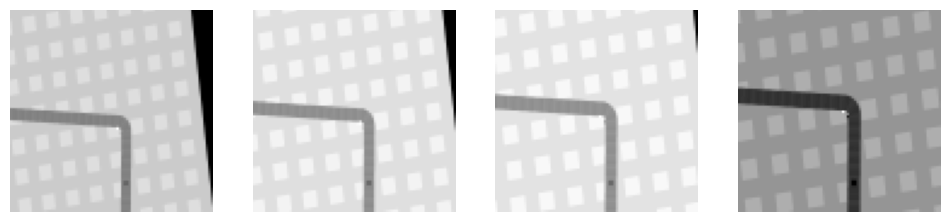

In [ ]:
pic1, pic2, pic3, pic4 = obs
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

axes[0].imshow(pic1, cmap='gray')
axes[0].axis('off')

axes[1].imshow(pic2, cmap='gray')
axes[1].axis('off')

axes[2].imshow(pic3, cmap='gray')
axes[2].axis('off')

axes[3].imshow(pic4, cmap='gray')
axes[3].axis('off')
plt.show()